# Import libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Langkah 1: Load Dataset

In [2]:
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("imdb")
df = pd.DataFrame(dataset['train'])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df_pos = df[df['label'] == 1].head(100)
df_neg = df[df['label'] == 0].head(100)
df = pd.concat([df_pos, df_neg]).reset_index(drop=True)

print(f"Jumlah data: {len(df)}")
print(df['label'].value_counts())  # Harus 100-100
print("Contoh teks positif:", df[df['label']==1]['text'].iloc[0][:100])
print("Contoh teks negatif:", df[df['label']==0]['text'].iloc[0][:100])

df['length'] = df['text'].apply(lambda x: len(word_tokenize(x)))
print("Rata-rata panjang:", df['length'].mean())
print("Min panjang:", df['length'].min(), "Max:", df['length'].max())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 re

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Jumlah data: 200
label
1    100
0    100
Name: count, dtype: int64
Contoh teks positif: I dug out from my garage some old musicals and this is another one of my favorites. It was written b
Contoh teks negatif: Dumb is as dumb does, in this thoroughly uninteresting, supposed black comedy. Essentially what star
Rata-rata panjang: 267.26
Min panjang: 38 Max: 1337


# Langkah 2: Preprocessing

In [3]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

df['tokens'] = df['text'].apply(preprocess_text)

all_tokens = [token for tokens in df['tokens'] for token in tokens]
vocab = Counter(all_tokens).most_common(5000)
vocab = {word: idx+2 for idx, (word, _) in enumerate(vocab)}  # +2 buat padding (0) dan unknown (1)
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def tokens_to_indices(tokens):
    return [vocab.get(token, 1) for token in tokens]  # 1 buat unknown

df['indices'] = df['tokens'].apply(tokens_to_indices)

max_len = 200
def pad_sequence(seq):
    if len(seq) > max_len:
        return seq[:max_len]
    return seq + [0] * (max_len - len(seq))  # Pad with 0

df['padded'] = df['indices'].apply(pad_sequence)

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

X = np.array(df['padded'].tolist())
y = df['label_encoded'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Langkah 3: Define Model

In [4]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, bidirectional=False, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 2)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embed = self.embedding(x)
        _, (hn, _) = self.lstm(embed)
        out = self.dropout(hn[-1])
        return self.fc(out)

vocab_size = len(vocab) + 1
embed_dim = 100
hidden_dim = 128
num_layers = 2
dropout = 0.5

model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, num_layers, dropout)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Langkah 4: Training Loop

Epoch 1: Train Loss 0.6964, Val Loss 0.6906, Val Acc 0.4750
Epoch 2: Train Loss 0.6844, Val Loss 0.6948, Val Acc 0.4500
Epoch 3: Train Loss 0.6743, Val Loss 0.6904, Val Acc 0.4500
Epoch 4: Train Loss 0.6571, Val Loss 0.6890, Val Acc 0.4750
Epoch 5: Train Loss 0.6112, Val Loss 0.6927, Val Acc 0.5500
Epoch 6: Train Loss 0.5588, Val Loss 0.6678, Val Acc 0.5000
Epoch 7: Train Loss 0.5114, Val Loss 0.5636, Val Acc 0.6000
Epoch 8: Train Loss 0.4882, Val Loss 0.6942, Val Acc 0.5750
Epoch 9: Train Loss 0.4373, Val Loss 0.7777, Val Acc 0.6250
Epoch 10: Train Loss 0.4310, Val Loss 0.7793, Val Acc 0.5750


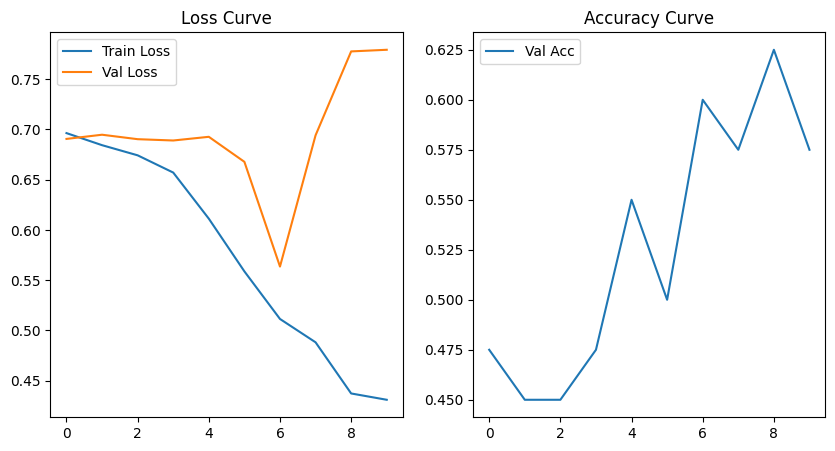

In [5]:
num_epochs = 10
train_losses = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    preds = []
    trues = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            trues.extend(y_batch.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    acc = accuracy_score(trues, preds)
    val_accs.append(acc)
    
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, Val Acc {acc:.4f}")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Langkah 5: Evaluasi

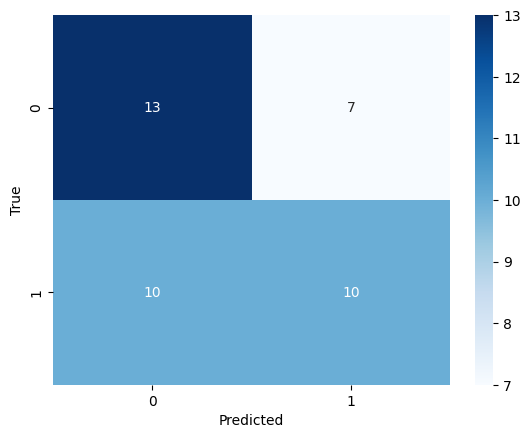

Final Val Acc: 0.575


In [6]:
cm = confusion_matrix(trues, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Final Val Acc:", val_accs[-1])

torch.save(model.state_dict(), 'lstm_model.pth')